<div style="text-align: center">
<img src="https://github.com/xCDAT/xcdat/raw/main/docs/_static/xcdat_logo.png" alt="xCDAT logo" style="display: inline-block; width:35%;">
</div>
</div>

<h1 style="text-align: lef;">A gentle introduction to xCDAT (Xarray Climate Data Analysis Tools)</h1>
<h3 style="text-align: left;">A package for simple and robust climate data analysis</h2>
<h3 style="text-align: left; font-style:italic">Tom Vo, Stephen Po-Chedley, Jason Boutte, Jill Zhang, Jiwoo Lee</h3>

---
<p style="text-align: left;">With thanks to Peter Gleckler, Paul Durack, Karl Taylor, and Chris Golaz</p>


_This work is performed under the auspices of the U. S. DOE by Lawrence Livermore National Laboratory under contract No. DE-AC52-07NA27344._

## Presentation Overview

Intended audience: No or some familiarity with xarray and xcdat 

What we will cover:

* What is xCDAT?
* An overview of Xarray
  * Historial Context
  * Key features and capabilities
  * The Xarray data models (xr.Dataset, xr.DataArray)
  * Resources for learning Xarray
* How does xCDAT fit in the Xarray ecosystem?
* The API design of xCDAT
  - Understand how to leverage xCDAT with Xarray
* Demo of xCDAT capabilities

## What is xCDAT?

* xCDAT is a lightweight extension of xarray for climate data analysis on structured grids 
* This package is jointly developed by scientists and developers from E3SM and PCMDI
    * Performed for the E3SM and SEATS (Simplifying ESM Analysis Through Standards) projects
    
<div style="text-align: center">   
<img src="https://e3sm.org/wp-content/uploads/2019/05/E3SM_Logo.jpg" alt="E3SM logo" style="display: inline-block; width:25%;">
<img src="https://pcmdi.llnl.gov/Data/media/images/220224_durack1_PCMDILogoWithText-trim-940Wpx-png8.png" alt="PCMDI logo" style="display: inline-block; width:25%;">    
<img src="https://www.seatstandards.org/SEATSlogo.png" alt="SEATS logo" style="display: inline-block; width:25%;">

</div>

## Let's Begin with Xarray

### Historical context:
* Xarray is an evolution of an internal tool developed at The Climate Corporation
* Released as open source in May 2014
* NumFocus fiscally sponsored project since August 2018


<div style="text-align: center">
    <img src="https://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png" alt="xarray logo" style="display: inline-block; width:25%;">
    <img src="https://xarray.dev/NumFOCUS_sponsored_project_logo.svg" alt="NumFOCUS logo" style="display: inline-block; width:25%;">
</div>


### Key Features and Capabilities in Xarray

* “N-D labeled arrays and datasets in Python”
    * Based on NumPy, heavily inspired by Pandas
    * Supports I/O for netCDF, Iris, OPeNDAP, Zarr, and GRIB.
* Interoperable with scientific Python ecosystem including NumPy, Dask, Pandas, and Matplotlib
* Features include:
    * File I/O, indexing and selecting, interpolating, grouping, aggregating, parallelism (Dask), plotting (matplotlib wrapper)
    

Source: https://xarray.dev/#features


## The Xarray Data Models in a Nutshell

**_"Xarray data models are borrowed from netCDF file format, which provides xarray with a natural and portable serialization format."_**

* `xarray.DataArray`
  * A class that attaches dimension names, coordinates, and attributes to multi-dimensional arrays
* `xarray.Dataset`
  * Dictionary-like containers of DataArrays, mapping a variable name to each DataArray

Source: https://docs.xarray.dev/en/stable/getting-started-guide/why-xarray.html#core-data-structures

## The `DataArray` Model

Xarray’s implementation of a labeled, multi-dimensional array. 

It has several key properties:

* `values`: a numpy.ndarray holding the array’s values
* `dims`: dimension names for each axis (e.g., ('x', 'y', 'z'))
* `coords`: a dict-like container of arrays (coordinates) that label each point (e.g., 1-dimensional arrays of numbers, datetime objects or strings)
* `attrs`: dict to hold arbitrary metadata (attributes)


<div style="text-align: center">
    <img src="https://docs.xarray.dev/en/stable/_images/dataset-diagram.png" alt="xarray logo" style="display: inline-block; width:50%">
</div>

Source: https://docs.xarray.dev/en/stable/user-guide/data-structures.html#dataarray

## The `Dataset` Model

A dictionary-like container of labeled arrays (DataArray objects) with aligned dimensions. 

Datasets have four key properties:
* `dims`: a dictionary mapping from dimension names to the fixed length of each dimension (e.g., {'x': 6, 'y': 6, 'time': 8})
* `data_vars`: a dict-like container of DataArrays corresponding to variables
* `coords`: another dict-like container of DataArrays intended to label points used in data_vars (e.g., arrays of numbers, datetime objects or strings)
* `attrs`: dict to hold arbitrary metadata

<div style="text-align: center">
    <img src="https://docs.xarray.dev/en/stable/_images/dataset-diagram.png" alt="xarray logo" style="display: inline-block; width:50%">
</div>

Source: https://docs.xarray.dev/en/stable/user-guide/data-structures.html#dataset


### Let's look at a netCDF4 dataset!

We will open a netCDF4 file from ESGF using OPeNDAP.

This dataset contains the `tas` variable, which represents near-surface air temperature.

In [86]:
import xarray as xr

filepath = "http://esgf.nci.org.au/thredds/dodsC/master/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/Amon/tas/gn/v20200605/tas_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc"

ds = xr.open_dataset(filepath)
ds

<xarray.Dataset>
Dimensions:    (time: 1980, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/49)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           87658.0
    creation_date:                   2020-06-05T04:06:11Z
    ...                              ...
    version:                         v20200605
    license:                         CMIP6 model data produced by CSIRO is li...
    cmor_version:                    3.4.0
    _NCProperties:                   version=2,netcdf=4.6.2,hdf5=1.10.5
    tracking_id:                     hdl:21.14100/af78ae5e-f3a6-4e99-8cfe-5f2...
    DODS_EXTRA.Unlimited_Dimension:  time

In [87]:
ds.tas

<xarray.DataArray 'tas' (time: 1980, lat: 145, lon: 192)>
[55123200 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    comment:        near-surface (usually, 2 meter) air temperature
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2020-06-05T04:06:10Z altered by CMOR: Treated scalar dime...
    _ChunkSizes:    [  1 145 192]

## Resources for Learning Xarray
* Now that you have a general sense of xarray data models, you can apply the numerous xarray APIs on these objects to perform analysis work.

* Here are some highly recommended resources:

  * [Xarray Documentation](https://docs.xarray.dev/en/stable/index.html)
  * [Xarray API Reference](https://docs.xarray.dev/en/stable/api.html)
  * [Tutorial: "Xarray in 45 minutes"](https://tutorial.xarray.dev/overview/xarray-in-45-min.html#) 

## So how does xCDAT fit in the Xarray Ecosystem?

_"Xarray is designed as a general purpose library, and hence tries to avoid including overly domain specific functionality. But inevitably, the need for more domain specific logic arises."_

* The goal of xCDAT is to provide generalizable climate domain features and utilities for simple and robust analysis of climate data. 
* xCDAT's design philosophy is centered on reducing the overhead required from xarray users to accomplish specific tasks. 


## xCDAT Available Features

* Extension of xarray's ``open_dataset()`` and ``open_mfdataset()`` with post-processing options

  * Generate bounds for axes supported by ``xcdat`` if they don't exist in the Dataset
  * Optional selection of single data variable to keep in the Dataset (bounds are also
    kept if they exist)
  * Optional decoding of time coordinates

    * In addition to CF time units, also decodes common non-CF time units
      ("months since ...", "years since ...")

  * Optional centering of time coordinates using time bounds
  * Optional conversion of longitudinal axis orientation between [0, 360) and [-180, 180)

* Temporal averaging
  * Time series averages (single snapshot and grouped), climatologies, and departures
  * Weighted or unweighted
  * Optional seasonal configuration (e.g., DJF vs. JFD, custom seasons)
* Geospatial weighted averaging
  * Supports rectilinear grid
  * Optional specification of regional domain
* Horizontal structured regridding
  * Supports rectilinear and curvilinear grids
  * Python implementation of `regrid2`_ for handling cartesian latitude longitude grids
  * API that wraps `xESMF`_

## xCDAT API Design

xCDAT provides public APIs in two ways:

1. Top-level APIs functions
2. Accessor classes
  * xcdat provides `Dataset` accessors, which are implicit namespaces for custom functionality.
  * Accessor namespaces clearly identifies separation from built-in xarray methods. 
  * In the example below, custom spatial functionality is exposed by chaining the spatial accessor attribute to the Dataset object. This chaining enables access to the underlying spatial average() method.


<div style="text-align: center">
    <img src="https://xcdat.readthedocs.io/en/latest/_images/accessor_api.svg" alt="xcdat accessor" style="display: inline-block; width:50%">
</div>



## A Demo of xCDAT Capabilities

1. Opening a dataset and applying xcdat operations
2. Calculate the spatial averages over the tropical region
3. Calculate the annual anomalies
4. Horizontal regridding (bilinear, gaussian grid)

### Import the `xcdat` package

In [100]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

# This gives access to all xcdat public top-level APIs and accessor classes.
import xcdat as xc

### Open up a dataset and run xcdat operations

* Add bounds for axes if they don't exist
* Decode time coordinates
* Center time coordinates using time bounds

In [115]:
filepath = "http://esgf.nci.org.au/thredds/dodsC/master/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r10i1p1f1/Amon/tas/gn/v20200605/tas_Amon_ACCESS-ESM1-5_historical_r10i1p1f1_gn_185001-201412.nc"

ds = xc.open_dataset(
    filepath, 
    add_bounds=True, 
    decode_times=True, 
    center_times=True
)

ds["tas"] = ds.tas - 273.15

In [116]:
print(ds)

<xarray.Dataset>
Dimensions:    (time: 1980, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    height     float64 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 -27.19 -27.19 -27.19 ... -25.29 -25.29
Attributes: (12/49)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           87658.0
    creation_date:                   2020-06-05T04:06:11Z
    ...                              ...
    version:                         v20200

### Example 1: Calculate the Spatial Average over the Tropical Region

In [117]:
ds_trop_avg = ds.spatial.average("tas", axis=["X","Y"], lat_bounds=(-25,25))

In [118]:
ds_trop_avg.tas

<xarray.DataArray 'tas' (time: 1980)>
array([25.24722608, 25.61795924, 25.96516235, ..., 26.79536823,
       26.67771602, 26.27182383])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
    height   float64 2.0

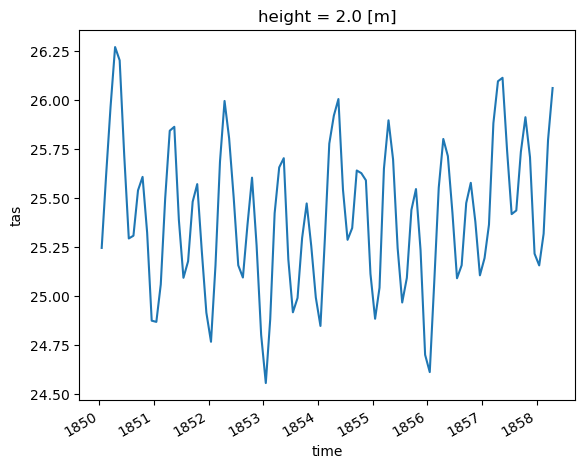

In [119]:
# Plot the first 100 time steps
ds_trop_avg.tas.isel(time=slice(0, 100)).plot()

### Example 2: Calculate temporal average (single snapshot)

In [120]:
ds_avg = ds.temporal.average("tas", weighted=True)

In [121]:
ds_avg.tas

<xarray.DataArray 'tas' (lat: 145, lon: 192)>
array([[-48.01481628, -48.01481628, -48.01481628, ..., -48.01481628,
        -48.01481628, -48.01481628],
       [-44.94085363, -44.97948214, -45.01815398, ..., -44.82408252,
        -44.86273067, -44.9009281 ],
       [-44.11875274, -44.23060624, -44.33960158, ..., -43.76766492,
        -43.88593717, -44.00303006],
       ...,
       [-18.21076615, -18.17513373, -18.13957458, ..., -18.32720478,
        -18.28428828, -18.2486193 ],
       [-18.50778243, -18.49301854, -18.47902819, ..., -18.55410851,
        -18.5406963 , -18.52413098],
       [-19.07366375, -19.07366375, -19.07366375, ..., -19.07366375,
        -19.07366375, -19.07366375]])
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
    height   float64 2.0
Attributes:
    operation:  temporal_avg
    mode:       average
    freq:       month
    weighted:   True

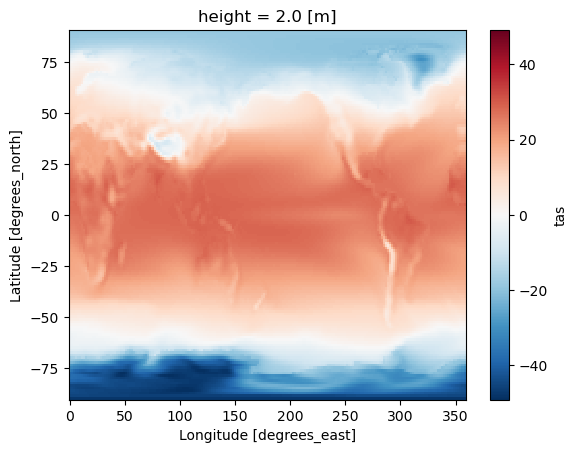

In [122]:
ds_avg.tas.plot(label="weighted")

### Example 3: Horizontal Regridding with a Gaussian Grid
In this example, we will generate a gaussian grid with 32 latitudes to regrid our input data to.

#### Create the output grid

In [42]:
output_grid = xcdat.create_gaussian_grid(32)

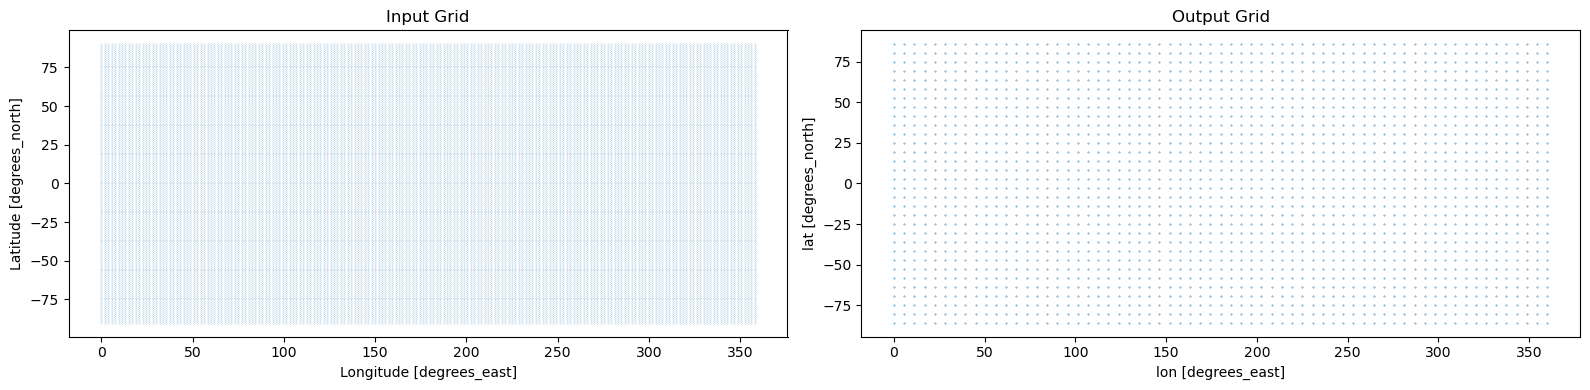

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 4))

ds.regridder.grid.plot.scatter('lon', 'lat', s=0.01, ax=axes[0])
axes[0].set_title('Input Grid')

output_grid.plot.scatter('lon', 'lat', s=0.1, ax=axes[1])
axes[1].set_title('Output Grid')

plt.tight_layout()

#### Regrid the data

xCDAT offers horizontal regridding with xESMF (default) and a Python port of regrid2.

In [49]:
# xesmf supports "bilinear", "conservative", "nearest_s2d", "nearest_d2s", and "patch"
output = ds.regridder.horizontal('tas', output_grid, tool='xesmf', method='bilinear')

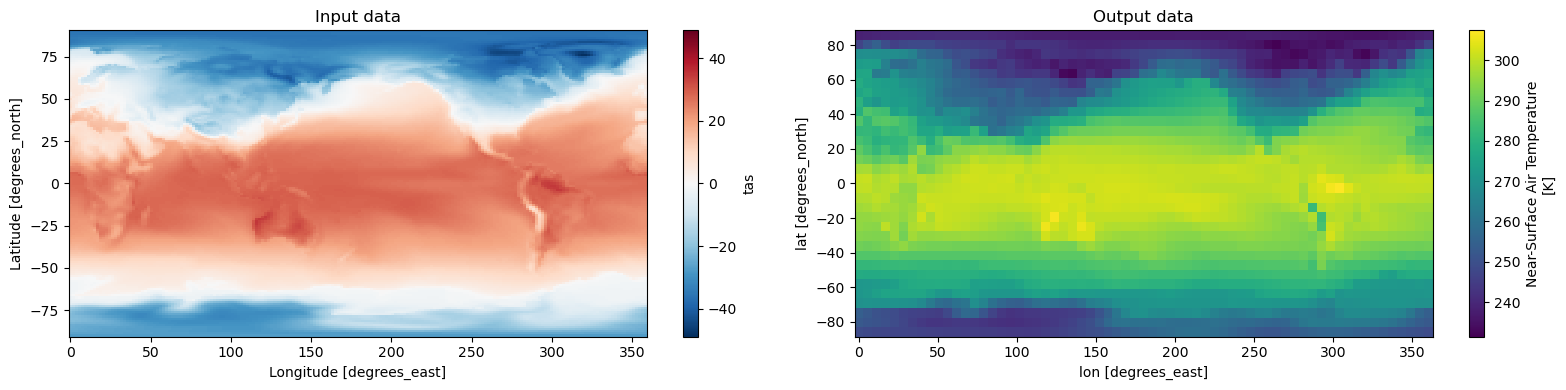

In [123]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 4))

ds.tas.isel(time=0).plot(ax=axes[0])
axes[0].set_title('Input data')

output.tas.isel(time=0).plot(ax=axes[1])
axes[1].set_title('Output data')

plt.tight_layout()